Week of 4/21

In [1]:
import json
#from google.colab import drive

# Get the notebook's filename (usually matches the GitHub repo name)
!ls *.ipynb
notebook_name = "NLPProject.ipynb"  # ← Replace with your filename

# Load and fix the notebook
with open(notebook_name, 'r') as f:
    nb = json.load(f)

# Option A: Remove widgets metadata completely (recommended)
if 'metadata' in nb and 'widgets' in nb['metadata']:
    del nb['metadata']['widgets']

# Option B: Or add the missing state key
# if 'metadata' in nb and 'widgets' in nb['metadata']:
#     nb['metadata']['widgets']['state'] = {}

# Save the fixed version
with open(notebook_name, 'w') as f:
    json.dump(nb, f)

print("Notebook metadata fixed! You can now commit to GitHub.")

NLPProject.ipynb  NLPProject2.ipynb NLPProject3.ipynb
Notebook metadata fixed! You can now commit to GitHub.


In [2]:
from pprint import pprint
from operator import itemgetter
import nltk
from nltk.corpus import framenet as fn
from nltk.corpus.reader.framenet import PrettyList
nltk.download('framenet_v17')

[nltk_data] Downloading package framenet_v17 to
[nltk_data]     /Users/kierstenwener/nltk_data...
[nltk_data]   Package framenet_v17 is already up-to-date!


True

In [3]:
frames_with_time_ex = {}
for f in fn.frames():
    for x in f.FE:
        if x == "Time":
            frames_with_time_ex[f.name] = f

In [4]:
def align_labels_with_tokens(text, char_labels, offsets):
    token_labels = []
    for start, end in offsets:
        if start == end:
            token_labels.append("O")  # Special tokens like [CLS], [SEP]
        else:
            # Majority vote over character labels inside the token span
            span_labels = char_labels[start:end]
            if all(lab == "O" for lab in span_labels):
                token_labels.append("O")
            elif span_labels[0] == "B-Time":
                token_labels.append("B-Time")
            else:
                token_labels.append("I-Time")
    return token_labels


In [5]:
import torch
from nltk.corpus import framenet as fn
from transformers import BertTokenizerFast

# Initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Map BIO tags to IDs
label2id = {"O": 0, "B-Time": 1, "I-Time": 2}
input_ids_list = []
attention_masks_list = []
labels_list = []

# Find frames that include "Time" as a frame element

for name, frame in frames_with_time_ex.items():
    # Print the frame name for reference
    for lu in frame.lexUnit.values():
        #print(f"\nLexical Unit: {lu['name']}")
        lu_data = fn.lu(lu['ID'])
        for ex in lu_data['exemplars']:
            text = ex['text']
            char_labels = ["O"] * len(text)
            has_time_fe = False

            for fe in ex['FE']:
                for i in fe:
                    if i[2] == "Time":
                        start, end = i[0], i[1]
                        if start < end:
                            char_labels[start] = "B-Time"
                            for i in range(start+1, end):
                                char_labels[i] = "I-Time"
                            has_time_fe = True
            if not has_time_fe:
                continue


            # Tokenize
            tokenized = tokenizer(text, return_offsets_mapping=True, truncation=True, padding="max_length", max_length=128)
            input_ids = tokenized["input_ids"]
            attention_mask = tokenized["attention_mask"]
            offsets = tokenized["offset_mapping"]

            # Map character-level labels to token-level labels
            token_labels = align_labels_with_tokens(text, char_labels, offsets)
            label2id_binary = {"O": 0, "B-Time": 1, "I-Time": 2}  # Map both B-Time to 1 and I to 2
            # Pad remaining labels with -100 where attention mask is 0 (i.e., padding tokens)


            label_ids = [label2id_binary.get(lab, 0) for lab in token_labels]
            label_ids = [
                label if mask == 1 else -100 
                for label, mask in zip(label_ids, attention_mask)
            ]
            # Store tensors
            input_ids_list.append(torch.tensor(input_ids))
            attention_masks_list.append(torch.tensor(attention_mask))
            labels_list.append(torch.tensor(label_ids))

# Final dataset tensors
input_ids_tensor = torch.stack(input_ids_list)
attention_masks_tensor = torch.stack(attention_masks_list)
labels_tensor = torch.stack(labels_list)

print("Tensor shapes:")
print("Input IDs:", input_ids_tensor.shape)
print("Attention Masks:", attention_masks_tensor.shape)
print("Labels:", labels_tensor.shape)

/Users/kierstenwener/Desktop/NLPProject/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tensor shapes:
Input IDs: torch.Size([9013, 128])
Attention Masks: torch.Size([9013, 128])
Labels: torch.Size([9013, 128])


In [6]:
indices = (labels_tensor == 1).nonzero(as_tuple=False)
sample_idx, token_idx = indices[0].tolist()
token_id = input_ids_tensor[sample_idx][token_idx]
token = tokenizer.convert_ids_to_tokens([token_id])[0]
print(f"Token: {token}")

Token: when


In [7]:
tokens = tokenizer.convert_ids_to_tokens(input_ids_tensor[sample_idx])
print("Tokens:", tokens)

Tokens: ['[CLS]', 'she', 'had', 'seen', 'no', 'reason', 'to', 'abandon', 'it', 'when', 'she', 'came', 'to', 'med', '##ew', '##ich', 'two', 'years', 'ago', ',', 'even', 'though', 'she', 'might', 'now', 'have', 'been', 'able', 'to', 'afford', 'a', 'car', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PA

In [8]:
labels = labels_tensor[sample_idx]
for tok, label in zip(tokens, labels):
    print(f"{tok:15} -> {label.item()}")

[CLS]           -> 0
she             -> 0
had             -> 0
seen            -> 0
no              -> 0
reason          -> 0
to              -> 0
abandon         -> 0
it              -> 0
when            -> 1
she             -> 2
came            -> 2
to              -> 2
med             -> 2
##ew            -> 2
##ich           -> 2
two             -> 2
years           -> 2
ago             -> 2
,               -> 0
even            -> 0
though          -> 0
she             -> 0
might           -> 0
now             -> 0
have            -> 0
been            -> 0
able            -> 0
to              -> 0
afford          -> 0
a               -> 0
car             -> 0
.               -> 0
[SEP]           -> 0
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -100
[PAD]           -> -10

In [9]:
from torch.utils.data import TensorDataset

dataset = TensorDataset(input_ids_tensor, attention_masks_tensor, labels_tensor)


In [10]:
from torch.utils.data import DataLoader, RandomSampler, SubsetRandomSampler
from torch.utils.data import random_split
# Parameters
batch_size = 5
validation_split = 0.5

train_size = int((1 - validation_split) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),  # Shuffle the data
    batch_size=batch_size
)

# Create DataLoader for validation (without shuffling)
val_dataloader = DataLoader(
    val_dataset,
    sampler=SubsetRandomSampler(range(len(val_dataset))),  # Don't shuffle validation data
    batch_size=batch_size
)

In [11]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel

class FrameElementClassifier(nn.Module):
    def __init__(self, bert_model='bert-base-uncased'):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        #self.query_encoder = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
        self.token_projection = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 3)
        self.dropout = nn.Dropout(0.1)

    #def forward(self, input_ids, attention_mask, role_ids, role_mask):
    def forward(self, input_ids, attention_mask):
        # Encode sentence
        sentence_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        token_embeddings = sentence_outputs.last_hidden_state  # shape: (B, T, H)

        # Project sentence tokens
        token_embeddings = self.token_projection(token_embeddings)  # shape: (B, T, H)
        logits = self.classifier(token_embeddings)

        return logits  # Apply softmax for inference or use with CrossEntropyLoss

In [12]:
num_epochs = 20
accuracies = []
num_batches = 15

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FrameElementClassifier().to(device)
#class_weights = torch.tensor([0.4, 0.6]).to(device)  # Make Time more important
loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions_batch = 0
    total_predictions = 0
    
    # Training loop
    for i, batch in enumerate(train_dataloader):
        if i >= num_batches:
            break
        print(i)
        input_ids, attention_mask, target_index = [item.to(device) for item in batch]
        
        optimizer.zero_grad()
        
        probs = model(input_ids, attention_mask)
        loss = loss_fn(probs.view(-1, 3), target_index.view(-1))
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [19]:
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions_batch = 0
    total_predictions = 0
    
    # Training loop
    for i, batch in enumerate(train_dataloader):
        if i >= num_batches:
            break
        print(i)
        input_ids, attention_mask, target_index = [item.to(device) for item in batch]
        
        optimizer.zero_grad()
        
        probs = model(input_ids, attention_mask)
        loss = loss_fn(probs.view(-1, 3), target_index.view(-1))
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [13]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_true_labels = []
all_pred_labels = []

with torch.no_grad():
    for i, batch in enumerate(val_dataloader):
        if i >= num_batches:
            break
        input_ids, attention_mask, target_index = [item.to(device) for item in batch]

        logits = model(input_ids, attention_mask)
        predicted_tokens = torch.argmax(logits, dim=-1)

        mask = (target_index != -100)

        all_true_labels.extend(target_index[mask].view(-1).cpu().numpy())
        all_pred_labels.extend(predicted_tokens[mask].view(-1).cpu().numpy())

# Report
print("Classification Report (O, B-Time, I-Time):")
print(classification_report(all_true_labels, all_pred_labels, target_names=['O', 'B-Time', 'I-Time']))

print("Confusion Matrix:")
cm = confusion_matrix(all_true_labels, all_pred_labels)
print(cm)


Classification Report (O, B-Time, I-Time):
              precision    recall  f1-score   support

           O       0.95      0.96      0.96      1865
      B-Time       0.70      0.88      0.78        76
      I-Time       0.79      0.70      0.74       280

    accuracy                           0.92      2221
   macro avg       0.81      0.85      0.82      2221
weighted avg       0.92      0.92      0.92      2221

Confusion Matrix:
[[1789   24   52]
 [   8   67    1]
 [  80    5  195]]


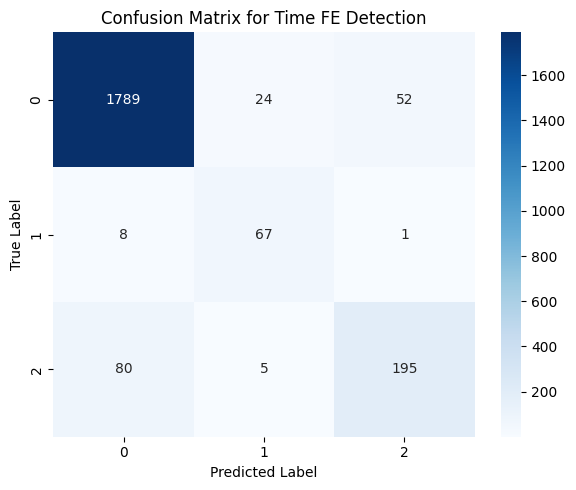

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Time FE Detection')
plt.tight_layout()
plt.show()

In [15]:
import numpy as np

true_np = np.array(all_true_labels)
pred_np = np.array(all_pred_labels)

for label_id, label_name in enumerate(['O', 'B-Time', 'I-Time']):
    total = np.sum(true_np == label_id)
    correct = np.sum((true_np == label_id) & (pred_np == label_id))
    print(f"{label_name} Accuracy: {correct}/{total} = {correct/total:.4f}")


O Accuracy: 1789/1865 = 0.9592
B-Time Accuracy: 67/76 = 0.8816
I-Time Accuracy: 195/280 = 0.6964


In [17]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel

class FrameElementClassifier2(nn.Module):
    def __init__(self, bert_model='bert-base-uncased'):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        #self.query_encoder = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
        self.token_projection = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 3)
        #increase dropout
        self.dropout = nn.Dropout(0.3)
        #reduce overfitting
        self.layernorm = nn.LayerNorm(self.bert.config.hidden_size)

    #def forward(self, input_ids, attention_mask, role_ids, role_mask):
    def forward(self, input_ids, attention_mask):
        # Encode sentence
        sentence_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        token_embeddings = sentence_outputs.last_hidden_state  # shape: (B, T, H)

        # Project sentence tokens
        token_embeddings = self.token_projection(token_embeddings)  # shape: (B, T, H)
        logits = self.classifier(token_embeddings)

        return logits  # Apply softmax for inference or use with CrossEntropyLoss

In [18]:
num_epochs = 20
accuracies = []
num_batches = 15

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = FrameElementClassifier2().to(device)
#class_weights = torch.tensor([0.4, 0.6]).to(device)  # Make Time more important
weights = torch.tensor([1.0, 5.0, 3.0]).to(device)
loss_fn2 = nn.CrossEntropyLoss(weight = weights, ignore_index=-100)
optimizer2 = torch.optim.AdamW(model2.parameters(), lr=2e-5)

for epoch in range(num_epochs):
    model2.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions_batch = 0
    total_predictions = 0
    
    # Training loop
    for i, batch in enumerate(train_dataloader):
        if i >= num_batches:
            break
        print(i)
        input_ids, attention_mask, target_index = [item.to(device) for item in batch]
        
        optimizer2.zero_grad()
        
        probs = model2(input_ids, attention_mask)
        loss = loss_fn2(probs.view(-1, 3), target_index.view(-1))
        
        loss.backward()
        optimizer2.step()

        running_loss += loss.item()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [19]:
from sklearn.metrics import classification_report, confusion_matrix

model2.eval()
all_true_labels2 = []
all_pred_labels2 = []

with torch.no_grad():
    for i, batch in enumerate(val_dataloader):
        if i >= num_batches:
            break
        input_ids, attention_mask, target_index = [item.to(device) for item in batch]

        logits = model2(input_ids, attention_mask)
        predicted_tokens = torch.argmax(logits, dim=-1)

        mask = (target_index != -100)

        all_true_labels2.extend(target_index[mask].view(-1).cpu().numpy())
        all_pred_labels2.extend(predicted_tokens[mask].view(-1).cpu().numpy())

# Report
print("Classification Report (O, B-Time, I-Time):")
print(classification_report(all_true_labels2, all_pred_labels2, target_names=['O', 'B-Time', 'I-Time']))

print("Confusion Matrix:")
cm2 = confusion_matrix(all_true_labels2, all_pred_labels2)
print(cm2)

Classification Report (O, B-Time, I-Time):
              precision    recall  f1-score   support

           O       0.98      0.91      0.95      1949
      B-Time       0.61      0.93      0.74        76
      I-Time       0.52      0.81      0.64       183

    accuracy                           0.90      2208
   macro avg       0.71      0.88      0.77      2208
weighted avg       0.93      0.90      0.91      2208

Confusion Matrix:
[[1777   41  131]
 [   2   71    3]
 [  31    4  148]]


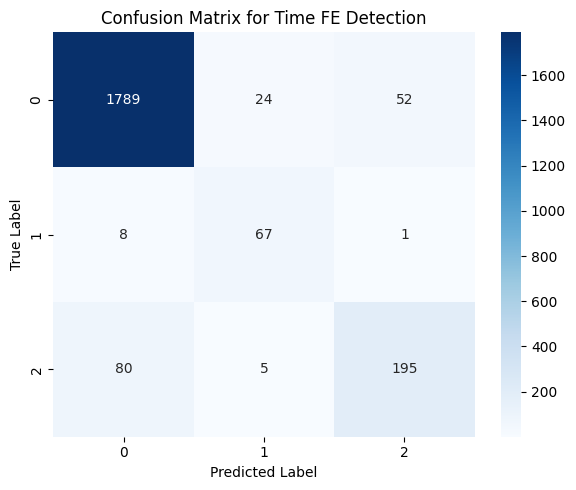

In [20]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Time FE Detection')
plt.tight_layout()
plt.show()